# xgriddedtime

In [1]:
import dask
import numpy as np
import pandas as pd
import sparse
import xarray as xr
from scipy.sparse import csr_matrix

## Generate Axes

In [2]:
def generate_time_and_bounds(bounds, fractions):
    """
    Generate time and time bounds

    Parameters
    ----------
    bounds : numpy.array
    fractions : numpy.array

    Returns
    -------
    ds : xarray.Dataset
    """
    time_bounds = np.vstack((bounds[:-1], bounds[1:])).T
    times = np.diff(time_bounds) * fractions.reshape(-1, 1) + time_bounds[:, 0].reshape(-1, 1)
    ds = xr.Dataset(
        {
            "time_bounds": xr.DataArray(
                time_bounds, dims=["time", "d2"], coords={"time": times.flatten()}
            )
        }
    )
    return ds

### Create Incoming Time Axis

In [3]:
# bounds = np.array([0.0, 10.0, 15.0, 22.0, 26.0, 38.0, 45.0])
# fractions = np.array([0.5, 0.4, 0.2, 1, 0.5, 0.3])
n = 13
bounds = np.round(np.logspace(2.0, 3.5, num=n), decimals=0)
fractions = np.round(np.random.random(n - 1), decimals=1)
incoming = generate_time_and_bounds(bounds, fractions)

### Create Outgoing Time Axis

In [4]:
# bounds = np.array([0, 15, 33, 46])
# fractions = np.array([0.4, 0.2, 1])
n = 25
bounds = np.round(np.logspace(2.0, 3.6, num=n), decimals=0)
fractions = np.round(np.random.random(n - 1), decimals=1)
outgoing = generate_time_and_bounds(bounds, fractions)

## Input Data

In [5]:
def create_dataset(times, time_bounds, dtype="float32", nlats=2, nlons=2):
    """
    Create synthetic dataset
    """

    shape = times.shape[0], nlats, nlons

    a = np.random.randint(0, 10, shape).astype(dtype)
    lats = np.linspace(start=-90, stop=90, num=nlats, dtype='float32')
    lons = np.linspace(start=-180, stop=180, num=nlons, dtype='float32')
    ds = xr.Dataset(
        {
            "x": xr.DataArray(
                a, dims=["time", "lat", "lon"], coords={"time": times, 'lon': lons, 'lat': lats}
            ),
            "time_bounds": xr.DataArray(time_bounds, dims=["time", "d2"]),
        }
    )
    return ds


ds = create_dataset(incoming["time"], incoming["time_bounds"])
# ds = ds.where(ds.x > 1)
ds

<xarray.Dataset>
Dimensions:      (d2: 2, lat: 2, lon: 2, time: 12)
Coordinates:
  * time         (time) float64 129.7 169.0 231.1 ... 2.312e+03 2.925e+03
  * lon          (lon) float32 -180.0 180.0
  * lat          (lat) float32 -90.0 90.0
Dimensions without coordinates: d2
Data variables:
    x            (time, lat, lon) float32 8.0 5.0 5.0 9.0 ... 2.0 4.0 2.0 1.0
    time_bounds  (time, d2) float64 100.0 133.0 133.0 ... 2.371e+03 3.162e+03

## Remapper

In [6]:
def _bounds_sanity_check(bounds):
    # Make sure lower_i <= upper_i
    if bounds.shape[1] > 1:
        if np.any(bounds[:, 0] > bounds[:, 1]):
            raise ValueError(
                "all lower bounds must be smaller than their counter-part upper bounds"
            )

        # Make sure lower_i < lower_{i+1}
        if np.any(bounds[0, :-1] >= bounds[0, 1:]):
            raise ValueError('lower bound values must be monotonically increasing.')


def get_coverage_info(incoming_time_bounds, outgoing_time_bounds):
    _bounds_sanity_check(incoming_time_bounds)
    _bounds_sanity_check(outgoing_time_bounds)
    incoming_lower_bounds = incoming_time_bounds[:, 0].data
    incoming_upper_bounds = incoming_time_bounds[:, 1].data
    outgoing_lower_bounds = outgoing_time_bounds[:, 0].data
    outgoing_upper_bounds = outgoing_time_bounds[:, 1].data

    n = incoming_lower_bounds.size
    m = outgoing_lower_bounds.size

    row_idx = []
    col_idx = []
    weights = []
    for r in range(m):
        toLB = outgoing_lower_bounds[r]
        toUB = outgoing_upper_bounds[r]
        toLength = toUB - toLB
        for c in range(n):
            fromLB = incoming_lower_bounds[c]
            fromUB = incoming_upper_bounds[c]
            fromLength = fromUB - fromLB

            if (fromUB <= toLB) or (fromLB >= toUB):  # No coverage
                continue
            elif (fromLB <= toLB) and (fromUB >= toLB) and (fromUB <= toUB):
                row_idx.append(r)
                col_idx.append(c)
                fraction_overlap = (fromUB - toLB) / fromLength
                weights.append(fraction_overlap * (fromLength / toLength))
            elif (fromLB >= toLB) and (fromLB < toUB) and (fromUB >= toUB):
                row_idx.append(r)
                col_idx.append(c)
                fraction_overlap = (toUB - fromLB) / fromLength
                weights.append(fraction_overlap * (fromLength / toLength))
            elif (fromLB >= toLB) and (fromUB <= toUB):
                row_idx.append(r)
                col_idx.append(c)
                fraction_overlap = 1.0
                weights.append(fraction_overlap * (fromLength / toLength))
            elif (fromLB <= toLB) and (fromUB >= toUB):
                row_idx.append(r)
                col_idx.append(c)
                fraction_overlap = (toUB - toLB) / fromLength
                weights.append(fraction_overlap * (fromLength / toLength))

    coverage = {
        "weights": weights,
        "col_idx": col_idx,
        "row_idx": row_idx,
        "shape": (m, n),
    }
    return coverage


def construct_coverage_matrix(weights, col_idx, row_idx, shape, coords={}):
    wgts = csr_matrix((weights, (row_idx, col_idx)), shape=shape).tolil()
    mask = np.asarray(wgts.sum(axis=1)).flatten() == 0
    wgts[mask, 0] = np.nan
    wgts = sparse.COO.from_scipy_sparse(wgts)
    weights = xr.DataArray(data=wgts, dims=["outgoing", "incoming"], coords=coords)
    return weights


_OUTGOING_KEY = "outgoing"
_INCOMING_KEY = "incoming"


class Remapper:
    """
    Facilitates conversion between two time axis.

    Parameters
    ----------
    incoming_axis : xarray.Dataset
    outgoing_axis : xarray.Dataset
    time_coord_name : str

    """

    def __init__(self, incoming_axis, outgoing_axis, time_coord_name="time"):
        self.time_coord_name = time_coord_name
        self.incoming_axis = incoming_axis
        self.outgoing_axis = outgoing_axis
        self.coverage_info = None
        self.weights = self.generate_weights()

    def generate_weights(self):
        """
        Generate remapping weights.
        """
        self.coverage_info = get_coverage_info(
            self.incoming_axis["time_bounds"], self.outgoing_axis["time_bounds"]
        )
        coords = {"outgoing": outgoing.time.data, "incoming": incoming.time.data}
        weights = construct_coverage_matrix(
            self.coverage_info["weights"],
            self.coverage_info["col_idx"],
            self.coverage_info["row_idx"],
            self.coverage_info["shape"],
            coords=coords,
        )
        return weights

    def __call__(self, data):
        """
        Apply remapping weights to data.
        Parameters
        ----------
        data : xarray.DataArray, xarray.Dataset
            Data to map to new time frequency.
        Returns
        -------
        outdata : xarray.DataArray, xarray.Dataset
            Remapped data. Data type is the same as input data type.
        Raises
        ------
        TypeError
            if input data is not an xarray DataArray or xarray Dataset.
        """
        if isinstance(data, xr.DataArray):
            return self._remap_dataarray(data)
        elif isinstance(data, xr.Dataset):
            return self._remap_dataset(data)
        else:
            raise TypeError("input data must be xarray DataArray or xarray Dataset!")

    def _remap_dataarray(self, dr_in):
        weights = self.weights.copy()
        # Convert sparse matrix into a dense one to avoid TypeError when performing dot product
        # TypeError: no implementation found for 'numpy.einsum' on types that implement
        # __array_function__: [<class 'sparse._coo.core.COO'>, <class 'numpy.ndarray'>]
        weights.data = weights.data.todense()
        indata = _sanitize_input_data(dr_in, self.time_coord_name, self.weights)
        if isinstance(indata.data, dask.array.Array):
            incoming_time_chunks = dict(zip(indata.dims, indata.chunks))[self.time_coord_name][0]

            weights = weights.chunk({_OUTGOING_KEY: incoming_time_chunks})
            return _apply_weights(
                weights,
                indata,
                self.time_coord_name,
            )
        else:
            return _apply_weights(weights, indata, self.time_coord_name)

    def _remap_dataset(self, ds_in):
        raise NotImplementedError("Currently only works on xarray DataArrays")


def _sanitize_input_data(data, time_coord_name, weights):
    message = (
        f"The length ({data[time_coord_name].size}) of incoming time dimension does not match "
        f"with the provided remapper object's incoming time dimension ({weights[_INCOMING_KEY].size})"
    )
    assert data[time_coord_name].size == weights[_INCOMING_KEY].size, message
    indata = data.copy()
    indata[time_coord_name] = weights[_INCOMING_KEY].data
    return indata


def _apply_weights(weights, indata, time_coord_name):
    """
    Apply remapping weights to data. We apply weights normalization when we have missing values in the input data.
    """
    indata = indata.rename({time_coord_name: _INCOMING_KEY})
    nan_mask = indata.isnull()
    non_nan_mask = xr.ones_like(indata, dtype=np.int8)
    non_nan_mask = non_nan_mask.where(~nan_mask, 0)
    indata = indata.where(~nan_mask, 0)
    inverse_sum_effective_weights = np.reciprocal(xr.dot(weights, non_nan_mask))
    outdata = xr.dot(weights, indata) * inverse_sum_effective_weights
    return outdata.rename({_OUTGOING_KEY: time_coord_name})

### Remapper Object

- Create a remapper object by providing the incoming time axis information and the outgoing time axis information

In [7]:
remapper = Remapper(incoming_axis=incoming, outgoing_axis=outgoing)
remapper.incoming_axis

<xarray.Dataset>
Dimensions:      (d2: 2, time: 12)
Coordinates:
  * time         (time) float64 129.7 169.0 231.1 ... 2.312e+03 2.925e+03
Dimensions without coordinates: d2
Data variables:
    time_bounds  (time, d2) float64 100.0 133.0 133.0 ... 2.371e+03 3.162e+03

In [8]:
remapper.outgoing_axis

<xarray.Dataset>
Dimensions:      (d2: 2, time: 24)
Coordinates:
  * time         (time) float64 100.0 126.5 140.4 ... 3.075e+03 3.755e+03
Dimensions without coordinates: d2
Data variables:
    time_bounds  (time, d2) float64 100.0 117.0 117.0 ... 3.415e+03 3.981e+03

In [9]:
remapper.weights

Format,coo
Data Type,float64
Shape,"(24, 12)"
nnz,34
Density,0.11805555555555555
Read-only,True
Size,816
Storage ratio,0.4


In [10]:
remapper.weights.data.todense().sum(axis=1)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 0.47942387,        nan])

### Remapping Input Data

Once you have your remapper, performing operations is straight forward.

In [11]:
remapped_data = remapper(ds.x)

## Sanity Checks via Visualization

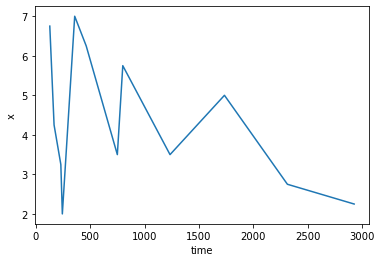

In [12]:
ds.x.mean(['lat', 'lon']).plot();

/Users/abanihi/opt/miniconda3/envs/analysis/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


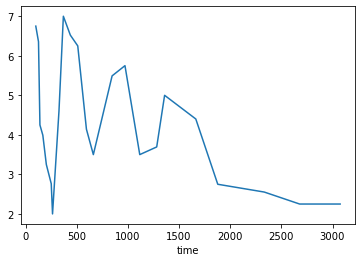

In [13]:
remapped_data.mean(['lat', 'lon']).plot();

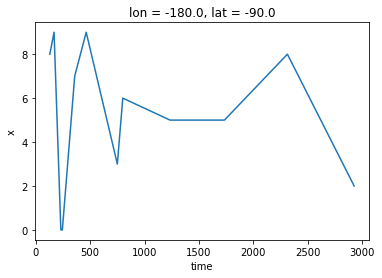

In [14]:
ds.isel(lat=0, lon=0).x.plot();

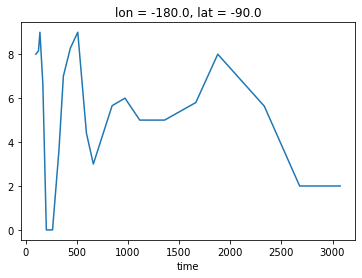

In [15]:
remapped_data.isel(lat=0, lon=0).plot();

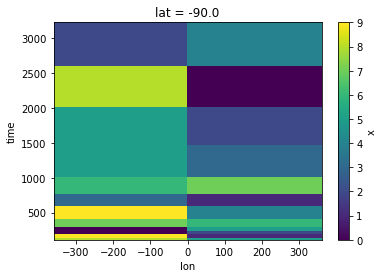

In [16]:
ds.isel(lat=0).x.plot();

Notice how the remapper data are filled with missing values for part of the time axis that span the period beyond incoming time axis end:

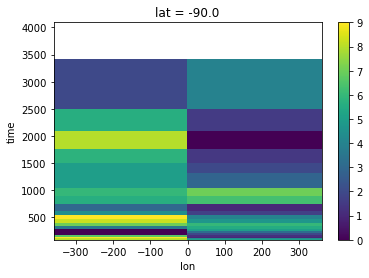

In [17]:
remapped_data.isel(lat=0).plot();

## Dask Support

When working with dask arrays, the chunking scheme of the input data is conserved during the remapping step, and the remapping is lazy:

In [18]:
ds = ds.chunk({'time': 6, 'lat': 1})
ds

<xarray.Dataset>
Dimensions:      (d2: 2, lat: 2, lon: 2, time: 12)
Coordinates:
  * time         (time) float64 129.7 169.0 231.1 ... 2.312e+03 2.925e+03
  * lon          (lon) float32 -180.0 180.0
  * lat          (lat) float32 -90.0 90.0
Dimensions without coordinates: d2
Data variables:
    x            (time, lat, lon) float32 dask.array<chunksize=(6, 1, 2), meta=np.ndarray>
    time_bounds  (time, d2) float64 dask.array<chunksize=(6, 2), meta=np.ndarray>

In [19]:
remapped_data = remapper(ds.x)
remapped_data

<xarray.DataArray (time: 24, lat: 2, lon: 2)>
dask.array<mul, shape=(24, 2, 2), dtype=float64, chunksize=(6, 1, 2), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) float64 100.0 126.5 140.4 ... 2.679e+03 3.075e+03 3.755e+03
  * lon      (lon) float32 -180.0 180.0
  * lat      (lat) float32 -90.0 90.0

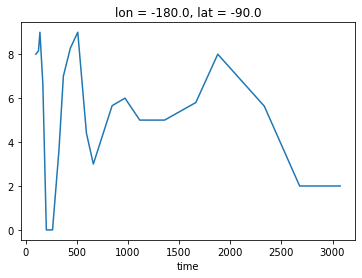

In [20]:
remapped_data.isel(lat=0, lon=0).plot();